# Day 19 GMM Examples

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 1.将GMM用作密度估计

虽然 GMM 通常被归类为聚类算法，但它本质上是一个密度估计算法;也就是说，从技术的角度考虑，一个 GMM 拟合的结果并不是一个聚类模型，而是描述数据分布的生成 概率模型。

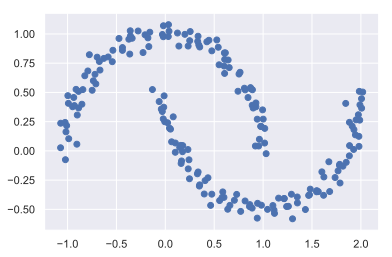

In [2]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

如果用 GMM 对数据拟合出两个成分，那么作为一个聚类模型的结果，其实没什么用:

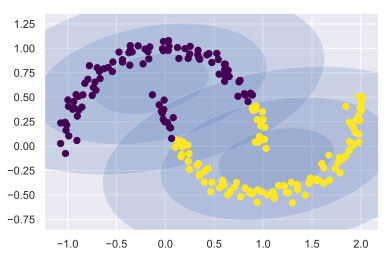

In [3]:
from sklearn.mixture import GaussianMixture

from matplotlib.patches import Ellipse
import warnings

warnings.filterwarnings(action='ignore')

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()
    
    # 将协方差转换成主轴
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # 画出椭圆
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_): #covariances_ --> covars_
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

但如果选用更多的成分而忽视簇标签，就可以找到一个更接近输入数据的拟合结果:

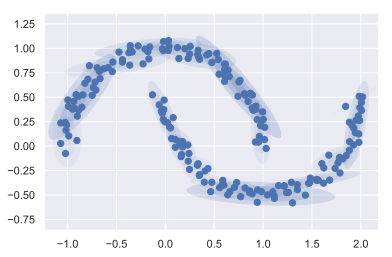

In [4]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

这里采用 16 个高斯曲线的混合形式**不是为了找到数据的分隔的簇，而是为了对输入数据 的总体分布建模。**
这就是**分布函数的生成模型**——GMM 可以为我们生成新的、与输入数 据类似的随机分布函数。

GMM 是一种非常方便的建模方法，可以为数据估计出任意维度的随机分布。

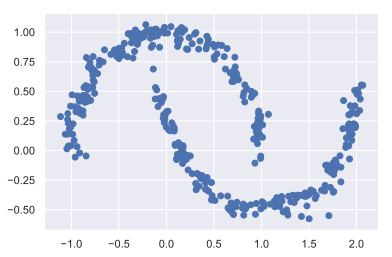

In [5]:
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

### 需要多少成分?
作为一种生成模型，GMM 提供了一种确定数据集最优成分数量的方法。由于生成模 型本身就是数据集的概率分布，因此可以利用该模型来评估数据的似然估计，并利用 交叉检验防止过拟合。还有一些纠正过拟合的标准分析方法，例如用赤池信息量准则(Akaike information criterion，AIC)、贝叶斯信息准则(Bayesian information criterion，BIC)

下面用 AIC 和 BIC 分别作为月球数据集的 GMM 成分数量的函数:

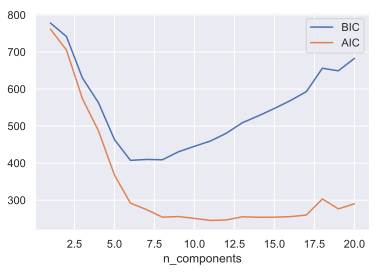

In [6]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

AIC告诉我们，选择 16 个成分可能太多，8个 ~12 个成分可能是更好的选择, 而BIC则推荐了一个更简单的模型。

这里需要注意的是:成分数量的选择度量的是 GMM 作为一个密度评估器的性能，而不是作为一个聚类算法的性能。建议还是把 GMM 当成一个密度评估器，仅在简单数据集中才将它作为聚类算法使用。

## 2.示例:用GMM生成新的数据

In [7]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

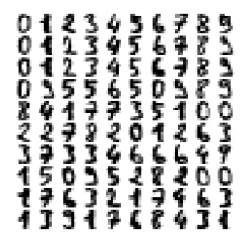

In [8]:
def plot_100_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(4, 4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_100_digits(digits.data)

现在有大约 1800 个 64 维度的数字，**可以创建一个 GMM 模型来生成更多的数字**。GMM 在这样一个高维空间中可能不太容易收敛，因此先使用一个不可逆的降维算法。我们在这里直接用 PCA，让 PCA 算法保留投影后样本数据 99% 的方差:

In [9]:
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten=True) # 让 PCA 降维保留投影后样本数据 99% 的方差
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

结果降到了 41 维，削减了接近 1/3 的维度的同时，几乎没有信息损失。再对这个投影数据 使用 AIC，从而得到 GMM 成分数量的粗略估计:

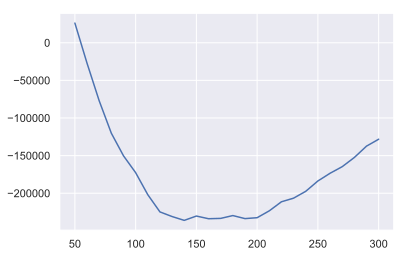

In [10]:
n_components = np.arange(50, 310, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

在大约 120 个成分的时候，AIC 是最小的，因此我们打算使用这个模型——立刻用它拟合数据，并且确认它已经收敛:

In [11]:
gmm = GaussianMixture(120, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


现在就可以在 41 维投影空间中画出这 100 个点的示例，将 GMM 作为生成模型:

In [12]:
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

最后，可以通过 PCA 对象逆变换来构建新的数字:

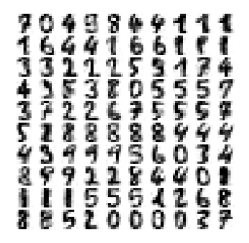

In [13]:
digits_new = pca.inverse_transform(data_new)
plot_100_digits(digits_new)

可以看出, 用GaussianMixture生成的新数据与原数据非常想像!